# Variational Inference for GMM

## import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from function.elbo_func import *

## data generation

In [2]:
n = 100
K = 5
Sig = np.diag([20,10])

np.random.seed(123)
mu_all = np.random.multivariate_normal([0,0], Sig, K)
c_all = np.random.multinomial(1, np.repeat(1/K, K), n)
means = c_all.dot(mu_all)
x_all = np.array([np.random.multivariate_normal(mi, np.eye(2)) for mi in means])

Let's see the plot...

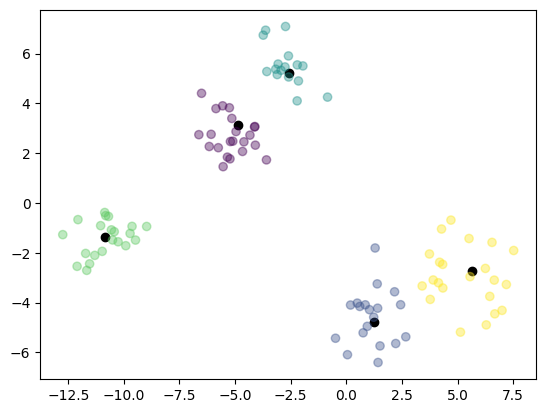

In [33]:
cols_mu = np.arange(0, K, 1, dtype=int)
cols_x = np.tile(cols_mu, (n, 1))[c_all == 1]

plt.scatter(mu_all[:,0], mu_all[:,1], c='k')
plt.scatter(x_all[:,0], x_all[:,1], c = cols_x, alpha=0.4)

# CAVI for GMM

## 1. initialization

In [26]:
dx = x_all.shape[1]

maxIter = 1000
tol = 1e-8

mFit_trace = np.zeros([K,dx,maxIter])
s2Fit_trace = np.zeros([dx,dx,K,maxIter])
clus_trace = np.zeros([n,maxIter])
phiFit_trace = np.zeros([n,K,maxIter])
elbo_trace = np.zeros(maxIter)

mFit_trace[:,:,0] = np.random.multivariate_normal([0,0], Sig, K)
s2Fit_trace[:,:,:,0] = np.dstack([np.eye(dx)]*K)
clus_trace[:,0] = np.zeros(n)
# clus_trace[:,0] = np.tile(np.array([1] + [0] * 4), (n,1))
phiFit_trace[:,:,0] = np.tile(np.repeat(1/K, K), (n,1))
elbo_trace[0] = elbo_calc(x_all,mFit_trace[:,:,0],\
                          s2Fit_trace[:,:,:,0],phiFit_trace[:,:,0],Sig)


In [27]:
for iter in range(1, maxIter):
    
    # step 1: update cluster assignment
    term1 = mFit_trace[:,:,iter - 1].dot(x_all.T)
    term2 = (np.trace(s2Fit_trace[:,:,:,iter-1]) +\
             np.sum(mFit_trace[:,:,iter - 1]**2, axis = 1))/2
    
    phi_unNorm = np.exp(term1.T - term2)
    row_sums = phi_unNorm.sum(axis=1)
    phiFit_trace[:,:,iter] = phi_unNorm / row_sums[:, np.newaxis]
    clus_trace[:,iter] = phiFit_trace[:,:,iter].argmax(axis=1)


    # step 2: update cluster parameters
    phiSum = phiFit_trace[:,:,iter].sum(axis = 0)
    s2Inv = np.dstack([np.linalg.inv(Sig)]*K) + phiSum*np.dstack([np.eye(dx)]*K)
    s2Tmp = np.linalg.inv(s2Inv.T).T

    for kk in range(K):
        phiX = np.multiply(phiFit_trace[:,kk,iter].reshape((-1,1)), x_all)
        phiX_sum = np.sum(phiX, axis = 0)
        mFit_trace[kk,:,iter] = s2Tmp[:,:,kk].dot(phiX_sum)

    s2Fit_trace[:,:,:,iter] = s2Tmp
    
    # step 3: evaluate the convergence of ELBO
    elbo_trace[iter] = elbo_calc(x_all,mFit_trace[:,:,iter],\
                          s2Fit_trace[:,:,:,iter],phiFit_trace[:,:,iter],Sig)
    elbo_change = np.abs(elbo_trace[iter] - elbo_trace[iter-1])/elbo_trace[iter]
    print('iter %d: elbo = %.3f, elbo_change = %.3f' % (iter, elbo_trace[iter], elbo_change))
    
    if elbo_change < tol:
        break

iter 1: elbo = 2254.546, elbo_change = 1.785
iter 2: elbo = 2391.298, elbo_change = 0.057
iter 3: elbo = 2466.561, elbo_change = 0.031
iter 4: elbo = 2491.549, elbo_change = 0.010
iter 5: elbo = 2498.340, elbo_change = 0.003
iter 6: elbo = 2500.092, elbo_change = 0.001
iter 7: elbo = 2500.482, elbo_change = 0.000
iter 8: elbo = 2500.563, elbo_change = 0.000
iter 9: elbo = 2500.580, elbo_change = 0.000
iter 10: elbo = 2500.583, elbo_change = 0.000
iter 11: elbo = 2500.584, elbo_change = 0.000
iter 12: elbo = 2500.584, elbo_change = 0.000
iter 13: elbo = 2500.584, elbo_change = 0.000
iter 14: elbo = 2500.584, elbo_change = 0.000


Before plotting, let's first calculate the similarity matrix...

In [ ]:
clus_true = cols_x
clus_fit = clus_trace[:,iter]
simMat = np.zeros([n,n])

for aa in range(n):
    for bb in range(n):
        simMat[aa,bb] = (clus_fit[aa] == clus_fit[bb])
        
idx_sort = np.argsort(clus_true)   
simMat_sort = simMat[:, idx_sort][idx_sort]

OK, now let's plot.

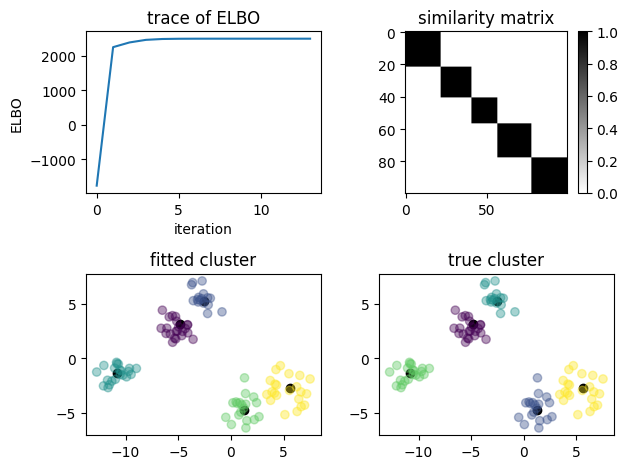

In [80]:
fig, ax = plt.subplots(2, 2)

ax[0,0].plot(elbo_trace[0:iter])
ax[0,0].set_xlabel('iteration')
ax[0,0].set_ylabel('ELBO')
ax[0,0].set_title('trace of ELBO')

pos = ax[0,1].imshow(simMat_sort, cmap='gray_r')
fig.colorbar(pos, ax=ax[0,1])
ax[0,1].set_title('similarity matrix')

ax[1,0].scatter(mu_all[:,0], mu_all[:,1], c='k')
ax[1,0].scatter(x_all[:,0], x_all[:,1], c = clus_trace[:,iter], alpha=0.4)
ax[1,0].set_title('fitted cluster')

ax[1,1].scatter(mu_all[:,0], mu_all[:,1], c='k')
ax[1,1].scatter(x_all[:,0], x_all[:,1], c = cols_x, alpha=0.4)
ax[1,1].set_title('true cluster')

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
